In [1]:
# Import modules
import pandas as pd
import numpy as np
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
pd.set_option('display.max_colwidth',1000)

TensorFlow Version: 2.2.0
Hub version:  0.8.0


### Start here:

In [2]:
df = pd.read_csv('US_patent_abstract_5000_2015_with_title_1.csv') # this file already shuffle the data
df

,Unnamed: 0,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,...,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,text
0,54639,US-8014303-B2,"A network device may include logic configured to receive a problem report from a second network device, where the problem report includes event data, determine at least one of an action to perform or whether reconfiguration information is associated with the event data in the received problem report and add information to the received problem report to provide a reformatted problem report and transmit the reformatted problem report to a third network device when it is determined that reconfiguration information is not associated with the event data in the problem report.",20101229,Systems and methods for interfacing with network information collection devices,"1. A device comprising:\n memory to store instructions, where the device is a first device; and \n a processor to execute the instructions to:\n receive a first message and a second message from a second device, where the first message and the second message differ, and where the first message includes a first header and first event data and the second message includes a second header and second event data, \n identify, based on the first header and the second header, that the first message and the second messages are problem reports, \n process, in response to identifying the first message and the second messages as the problem reports, the first event data to determine that the first event data, in the first message, is associated with a particular reconfiguration information, of a plurality of reconfiguration information corresponding with the second device, \n process, in response to identifying the first message and the second messages as the problem reports, the second event ...",US08014303,333595253,US08014303,2010,...,3,0,0.593750,0.751486,0.137931,5.0,0.250936,0.326616,0,"Systems and methods for interfacing with network information collection devices. A network device may include logic configured to receive a problem report from a second network device, where the problem report includes event data, determine at least one of an action to perform or whether reconfiguration information is associated with the event data in the received problem report and add information to the received problem report to provide a reformatted problem report and transmit the reformatted problem report to a third network device when it is determined that reconfiguration information is not associated with the event data in the problem report."
1,45032,US-9114955-B2,"Provided is a control device for an elevator to be operated with a speed pattern thereof being changed based on a load of the elevator, in which a control parameter is automatically adjusted in a short period so that the capability of a drive device is appropriately exhibited regardless of the magnitudes of travel resistance and mechanical loss that varies for each elevator, and consequently the elevator is operated with high efficiency, the control device including: a traveling model used for calculating the speed command value of the elevator; and means for automatically adjusting a parameter of the traveling model based on travel data during a travel of the elevator when the elevator is installed and adjusted.",20101208,Control device for elevator,"The invention claimed is: \n \n 1. A control system for an elevator, comprising:\n a sensor to sense a parameter of the elevator, when the elevator is moving; \n a calculator used to calculate a speed pattern to set a speed of the elevator, using information from the sensor obtained when the elevator is moving; \n a memory to store the speed pattern which sets a speed of the elevator; and \n a motor controller which controls movement of the elevator using the speed pattern stored in the memory. \n \n \n \n 2. A

In [3]:
np.percentile(df['quality_index_4'], 50)

0.278783736036865

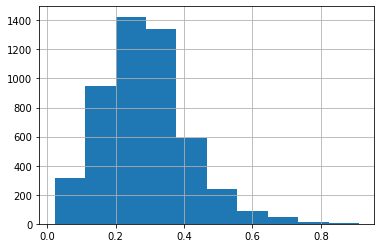

In [4]:
df['quality_index_4'].hist()

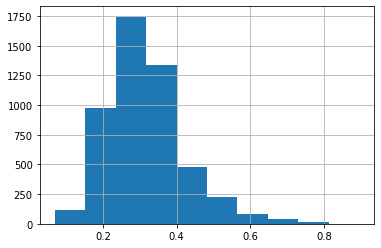

In [5]:
df['quality_index_6'].hist()

In [6]:
np.percentile(df['quality_index_6'], 50)

0.3021132266557215

In [7]:
df = df[['claims_text','quality_rank']]

In [8]:
df.head(5)

,claims_text,quality_rank
0,"1. A device comprising:\n memory to store instructions, where the device is a first device; and \n a processor to execute the instructions to:\n receive a first message and a second message from a second device, where the first message and the second message differ, and where the first message includes a first header and first event data and the second message includes a second header and second event data, \n identify, based on the first header and the second header, that the first message and the second messages are problem reports, \n process, in response to identifying the first message and the second messages as the problem reports, the first event data to determine that the first event data, in the first message, is associated with a particular reconfiguration information, of a plurality of reconfiguration information corresponding with the second device, \n process, in response to identifying the first message and the second messages as the problem reports, the second event ...",0
1,"The invention claimed is: \n \n 1. A control system for an elevator, comprising:\n a sensor to sense a parameter of the elevator, when the elevator is moving; \n a calculator used to calculate a speed pattern to set a speed of the elevator, using information from the sensor obtained when the elevator is moving; \n a memory to store the speed pattern which sets a speed of the elevator; and \n a motor controller which controls movement of the elevator using the speed pattern stored in the memory. \n \n \n \n 2. A control system for an elevator according to claim 1 , wherein the speed pattern comprises a pattern of a velocity or a pattern of an acceleration of the elevator. \n \n \n 3. A control system for an elevator according to claim 1 , wherein the calculator calculates the speed pattern using the information from the sensor which was obtained while a carrying load state of a car is changed in at least two ways when the elevator is installed...",1
2,"What is claimed is: \n \n 1. An image forming apparatus comprising:\n an image forming unit configured to form an image on a photosensitive member that is rotated by being driven by a motor; \n a detection unit configured to detect density information when a plurality of test patches formed by the image forming unit is irradiated with light, wherein the plurality of test patches is formed based on image data, and the image data is used for forming the plurality of test patches having density unevenness in a predetermined period corresponding to density unevenness occurring due to rotational unevenness of the motor in the predetermined period in a sub-scanning direction of the image and being different in start phase of the density unevenness in the predetermined period; and \n a control unit configured to cause the image forming unit to form an image with density being corrected based on detection results of detecting the density information of the plurality of test patch...",0
3,"The invention claimed is: \n \n 1. A switching power supply device having an input power supply and a load, comprising:\n a switching element disposed between the input power supply and the load; \n an inductive circuit coupled to the input power supply, supplying a current to the switching element; \n a power supply control integrated circuit for controlling the switching element to apply a constant output voltage to the load, the power supply control integrated circuit including\n a control circuit that controls operations of the power supply control integrated circuit, \n a drive circuit that, under the control of the control circuit, drives to turn on or off the switching element, \n a condition setting circuit that, under the control of the control circuit, determines an operation condition of the switching power supply device, and outputs a condition indicating signal indicating the operation condition, \n a control signal output terminal for outputting a drive sign...",1
4,"What is

In [9]:
df['claims_text'] = df['claims_text'].apply(str)

/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df.apply(lambda x: sum(x.isnull()), axis=0)

claims_text     0
quality_rank    0
dtype: int64

In [11]:
# Functions for constructing BERT Embeddings: input_ids, input_masks, input_segments and Inputs
MAX_SEQ_LEN=512 # max sequence length

def get_masks(tokens):
    """Masks: 1 for real tokens and 0 for paddings"""
    return [1]*len(tokens) + [0] * (MAX_SEQ_LEN - len(tokens))
 
def get_segments(tokens):
    """Segments: 0 for the first sequence, 1 for the second"""  
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (MAX_SEQ_LEN - len(tokens))

def get_ids(tokens, tokenizer):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (MAX_SEQ_LEN - len(token_ids))
    return input_ids

def create_single_input(sentence, tokenizer, max_len):
    """Create an input from a sentence"""
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:max_len]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer)
    masks = get_masks(stokens)
    segments = get_segments(stokens)

    return ids, masks, segments
 
def convert_sentences_to_features(sentences, tokenizer):
    """Convert sentences to features: input_ids, input_masks and input_segments"""
    input_ids, input_masks, input_segments = [], [], []
 
    for sentence in tqdm(sentences,position=0, leave=True):
      ids,masks,segments=create_single_input(sentence,tokenizer,MAX_SEQ_LEN-2)
      assert len(ids) == MAX_SEQ_LEN
      assert len(masks) == MAX_SEQ_LEN
      assert len(segments) == MAX_SEQ_LEN
      input_ids.append(ids)
      input_masks.append(masks)
      input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

def create_tonkenizer(bert_layer):
    """Instantiate Tokenizer with vocab"""
    vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
    do_lower_case=bert_layer.resolved_object.do_lower_case.numpy() 
    tokenizer=bert.bert_tokenization.FullTokenizer(vocab_file,do_lower_case)
    return tokenizer

In [12]:
def bert_model(callable_object):
    # Load the pre-trained BERT base model
    bert_layer = hub.KerasLayer(handle=callable_object, trainable=True)  
   
    # BERT layer three inputs: ids, masks and segments
    input_ids = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_ids")           
    input_masks = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="input_masks")       
    input_segments = Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name="segment_ids")
    
    inputs = [input_ids, input_masks, input_segments] # BERT inputs
    pooled_output, sequence_output = bert_layer(inputs) # BERT outputs
    
    # Add a hidden layer
    x = Dense(units=768, activation='relu')(pooled_output)
    x = Dropout(0.1)(x)
 
    # Add output layer
    outputs = Dense(1, activation="sigmoid")(x)

    # Construct a new model
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = bert_model("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]            

In [13]:
df['quality_rank'] = df['quality_rank'].astype(int)

/home/lin_menghsien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
# Create examples for training and testing
# df = df.sample(frac=1) # Shuffle the dataset  # already shuffle in the csv file
tokenizer = create_tonkenizer(model.layers[3])
X_train = convert_sentences_to_features(df['claims_text'][:4000], tokenizer)
X_test = convert_sentences_to_features(df['claims_text'][4000:], tokenizer)

# this one_hot_encoded seems like for multi-class
#one_hot_encoded = to_categorical(df['quality_rank'].values)
#y_train = one_hot_encoded[:4000]
#y_test =  one_hot_encoded[4000:]

# for binary classification, since in the loss function I use binary_crossentropy, looks like prefer this single array
y_train = df['quality_rank'][:4000]
y_test =  df['quality_rank'][4000:]




100%|██████████| 1000/1000 [00:15<00:00, 63.41it/s]


In [15]:
y_train.value_counts()

0    2320
1    1680
Name: quality_rank, dtype: int64

In [16]:
y_test.value_counts()

0    576
1    424
Name: quality_rank, dtype: int64

In [17]:
# Train the model
BATCH_SIZE = 10
EPOCHS = 2

# Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=2e-5)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Fit the data to the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose = 1)

# Save the trained model
model.save('bert_model_quality_index_4.h5')
model.save_weights('bert_weights_quality_index_4.h5')

Epoch 1/2
400/400 [==============================] - 7924s 20s/step - loss: 0.6760 - accuracy: 0.5842 - val_loss: 0.6528 - val_accuracy: 0.6260
Epoch 2/2
400/400 [==============================] - 7709s 19s/step - loss: 0.6382 - accuracy: 0.6317 - val_loss: 0.6451 - val_accuracy: 0.6490


In [19]:
pred_test_1 = model.predict(X_test)
pred_test_1

array([[0.44907582],
       [0.35327798],
       [0.298653  ],
       [0.6414262 ],
       [0.4120944 ],
       [0.35406554],
       [0.5448094 ],
       [0.18315673],
       [0.08098438],
       [0.25727457],
       [0.24505931],
       [0.16186252],
       [0.42899507],
       [0.35614562],
       [0.58766776],
       [0.4671013 ],
       [0.5120167 ],
       [0.5374232 ],
       [0.5027985 ],
       [0.15800002],
       [0.30128324],
       [0.3641205 ],
       [0.19057277],
       [0.13844904],
       [0.55427366],
       [0.48508254],
       [0.41994107],
       [0.5168493 ],
       [0.407623  ],
       [0.51646066],
       [0.29575127],
       [0.2674613 ],
       [0.28347507],
       [0.28543735],
       [0.306314  ],
       [0.2035749 ],
       [0.21214652],
       [0.7237647 ],
       [0.7188997 ],
       [0.28448117],
       [0.13085312],
       [0.6047352 ],
       [0.2955566 ],
       [0.26094377],
       [0.39080662],
       [0.66415673],
       [0.18331328],
       [0.241

In [41]:
# to convert to binary output
pred_test_binary = np.round(pred_test_1, 0)
pred_test_binary

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],

In [25]:
pred_test.shape

(1000,)

In [45]:
sum(pred_test_binary)

array([303.], dtype=float32)

In [29]:
y_test

4000    0
4001    0
4002    0
4003    0
4004    0
       ..
4995    1
4996    1
4997    0
4998    1
4999    0
Name: quality_rank, Length: 1000, dtype: int64

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test_binary))

              precision    recall  f1-score   support

           0       0.66      0.80      0.72       576
           1       0.62      0.44      0.52       424

    accuracy                           0.65      1000
   macro avg       0.64      0.62      0.62      1000
weighted avg       0.64      0.65      0.64      1000



In [44]:
np.unique(pred_test_binary, return_counts = True)

(array([0., 1.], dtype=float32), array([697, 303]))

In [47]:
np.savetxt('pred_test_BERT.csv', pred_test, delimiter =',') # save the prediction result